In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from analysis import collection, analysis

from pathlib import Path

import numpy as np
from scipy.optimize import curve_fit
from analysis import analysis
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams.update({'axes.labelsize': 16})

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

## visualize (one) ideal trial trajectory

- hitting the target isn't the maintenance of a particular force, it's rather the achievement of a particular force profile among muscles-- it's a "high dimensional button push"
- what's the "optimal" trajectory to reach that force profile? step? ramp? something in between? what is the function 
- what would make any function between (0,0) and target more or less optimal? based on what we know about the signal?


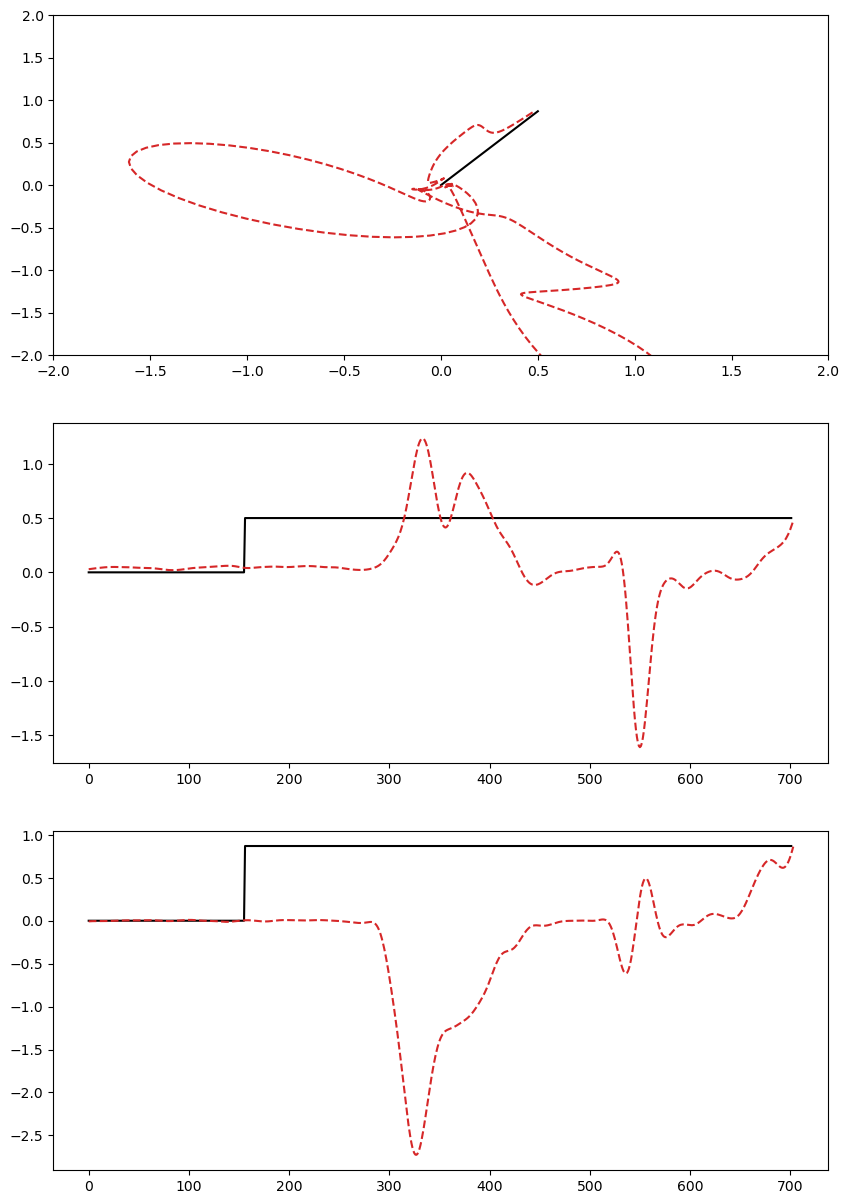

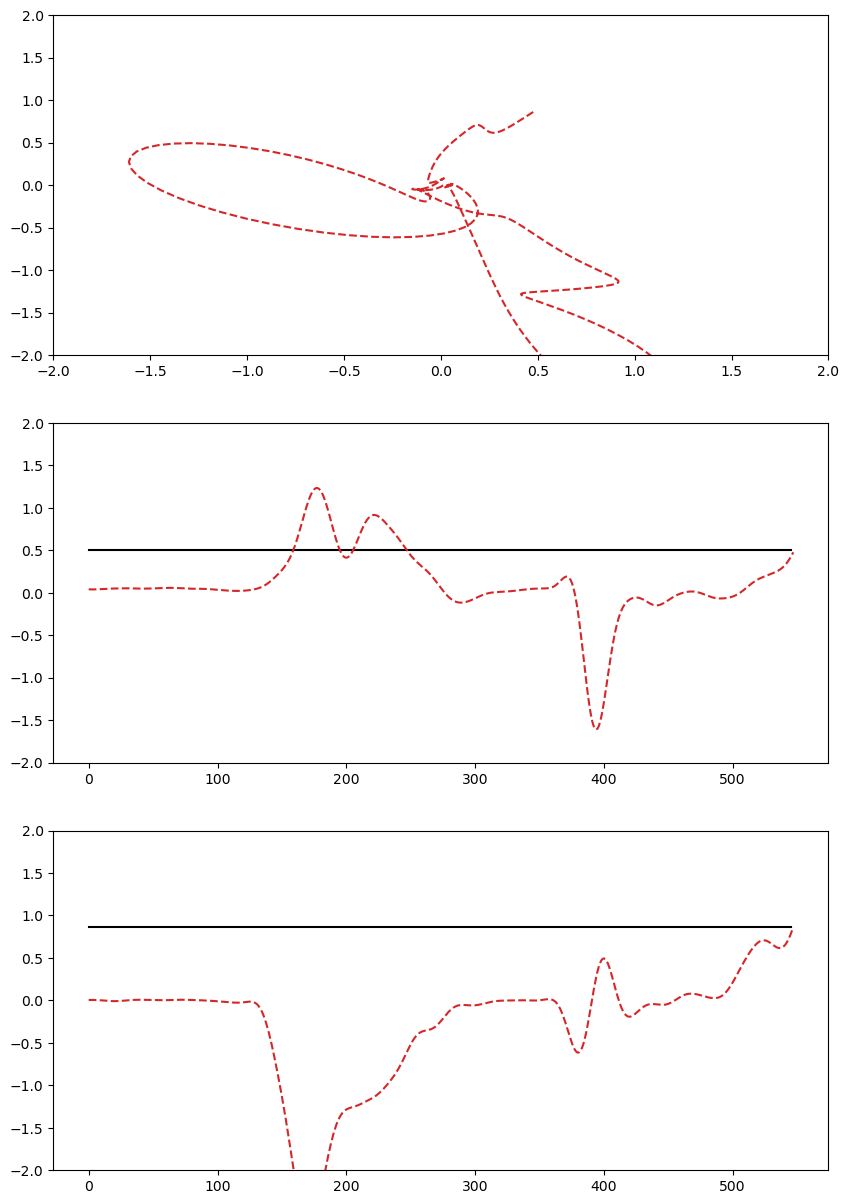

In [3]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

subject_idx = 10
target_idx = 3
session_idx = 5

fig, axes = plt.subplots(3,1,figsize=(10,15))
session = list(subjects[subject_idx].tasks[task_name].sorted_sessions())[session_idx]
for trial in session.sorted_trials():
    if trial.outcome == "Hit" and trial.target_number == target_idx:

        target = np.array(trial.target_coords)
        trajectory = trial.get_trajectory()[:,-2:]
        hold = np.zeros((2))
        hold_steps = int(200*trial.hold_time)
        hold_points = np.repeat(hold[:, np.newaxis], hold_steps, axis=1)

        movement_steps = int(200*trial.reach_time)

        reach_points_step = np.repeat(target[:, np.newaxis], movement_steps, axis=1)
        step_ideal = np.concatenate([hold_points, reach_points_step], axis=1).T

        axes[0].set_xlim([-2,2])
        axes[0].set_ylim([-2,2])
        axes[0].plot(step_ideal[:,0],step_ideal[:,1],"k")
        axes[1].plot(step_ideal[:,0],"k")
        axes[2].plot(step_ideal[:,1],"k")

        axes[0].plot(trajectory[:,0],trajectory[:,1],"--", color="tab:red")
        axes[1].plot(trajectory[:,0],"--", color="tab:red")
        axes[2].plot(trajectory[:,1],"--", color="tab:red")

# without the hold period

fig, axes = plt.subplots(3,1,figsize=(10,15))
session = list(subjects[subject_idx].tasks[task_name].sorted_sessions())[session_idx]
for trial in session.sorted_trials():
    if trial.outcome == "Hit" and trial.target_number == target_idx:

        trajectory = trial.get_trajectory()[hold_steps:,-2:]
        target = np.array(trial.target_coords)
        step_ideal = np.repeat(target[:, np.newaxis], movement_steps, axis=1).T

        axes[0].set_xlim([-2,2])
        axes[0].set_ylim([-2,2])
        axes[1].set_ylim([-2,2])
        axes[2].set_ylim([-2,2])
        axes[0].plot(step_ideal[:,0],step_ideal[:,1],"k")
        axes[1].plot(step_ideal[:,0],"k")
        axes[2].plot(step_ideal[:,1],"k")

        axes[0].plot(trajectory[:,0],trajectory[:,1],"--", color="tab:red")
        axes[1].plot(trajectory[:,0],"--", color="tab:red")
        axes[2].plot(trajectory[:,1],"--", color="tab:red")


## rotate targets to compare

In [4]:
def make_2d_rotation_matrix(angle):
    return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T

def rotation_matrix_from_target(target):
    # assume [x, y]
    assert target.shape == (2,), target.shape
    # the "closest" angle between the two targettors
    theta = np.arctan2(target[1],target[0])
    R = make_2d_rotation_matrix(theta)
    return R

def rotate(R, vec):
    return R @ vec

target = [-0.5, -0.87]
R = rotation_matrix_from_target(np.array(target))
rotate(R, np.array(target))

array([1.00344407e+00, 1.43781503e-16])

## test rotating targets

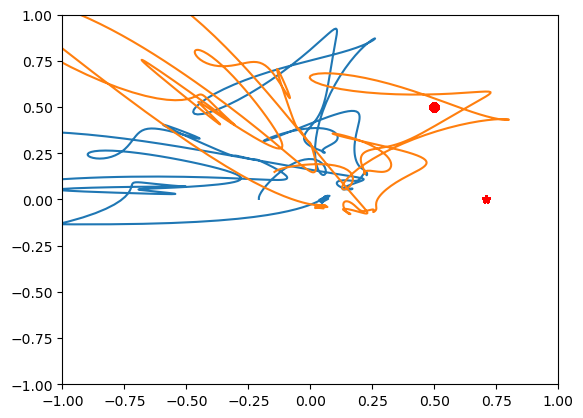

In [5]:
t = trial.get_trajectory()[:,-2:]
x = np.ones_like(t)
x[:,:] *= 0.5

plt.plot(x.T[0],x.T[1],"ro")
plt.plot(t.T[0],t.T[1])
plt.xlim([-1,1])
plt.ylim([-1,1])

R = rotation_matrix_from_target(np.array([np.sqrt(2)/2, np.sqrt(2)/2]))
t = R @ t.T
x = R @ x.T
plt.plot(x[0],x[1],"r*")
plt.plot(t[0],t[1])

## find the first "elbow" in the activation to just get movement activity

In [6]:
# where does the activity go below a threshold, then above?

def find_rise_points(sig):
    # assuming we've removed the hold steps
    # params
    num_to_avg = 10
    percentile = 0.15
    threshold = np.max(np.quantile(np.abs(sig),percentile,axis=0))

    # average the few steps of data
    offset = np.mean(sig[:num_to_avg,:],axis=0)

    # find the first point where values go above/below this average by a threshold amount
    # only use the "x" axis point
    return np.min(np.argmax(np.abs(sig - offset) > threshold, axis=0))

### test cutting off elbow 

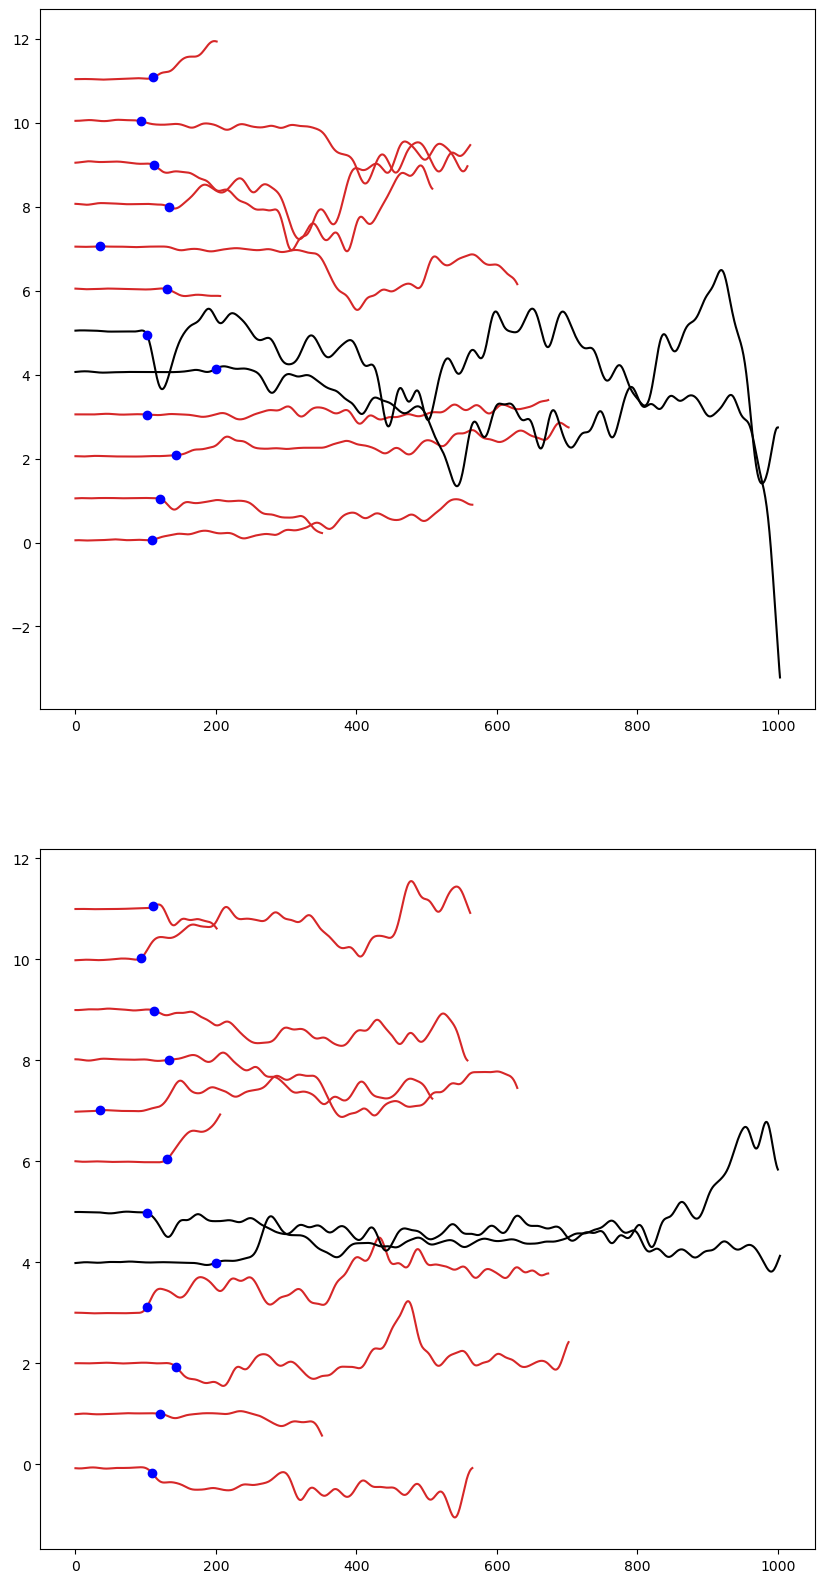

In [7]:
subject_idx = 10
session_idx = 39
trials = subjects[subject_idx].tasks[task_name].sorted_sessions()[session_idx].sorted_trials()

fig, axes = plt.subplots(2,1,figsize=(10,20))
i = 0
for trial in trials:
    oc = trial.outcome
    if oc in ["Hit", "Miss"]:
        sig = trial.get_trajectory()[int(200*trial.hold_time):,-2:]
        first_point = find_rise_points(sig)

        if oc == "Hit":
            c = "tab:red"
        elif oc == "Miss":
            c = "k"

        axes[0].plot(sig[:,0] + i, color=c)
        axes[1].plot(sig[:,1] + i, color=c)

        axes[0].plot(first_point,sig[first_point,0] + i, "bo")
        axes[1].plot(first_point,sig[first_point,1] + i, "bo")

        i +=1

### single session, rotated targets, remove start up to elbow

(-2.0, 2.0)

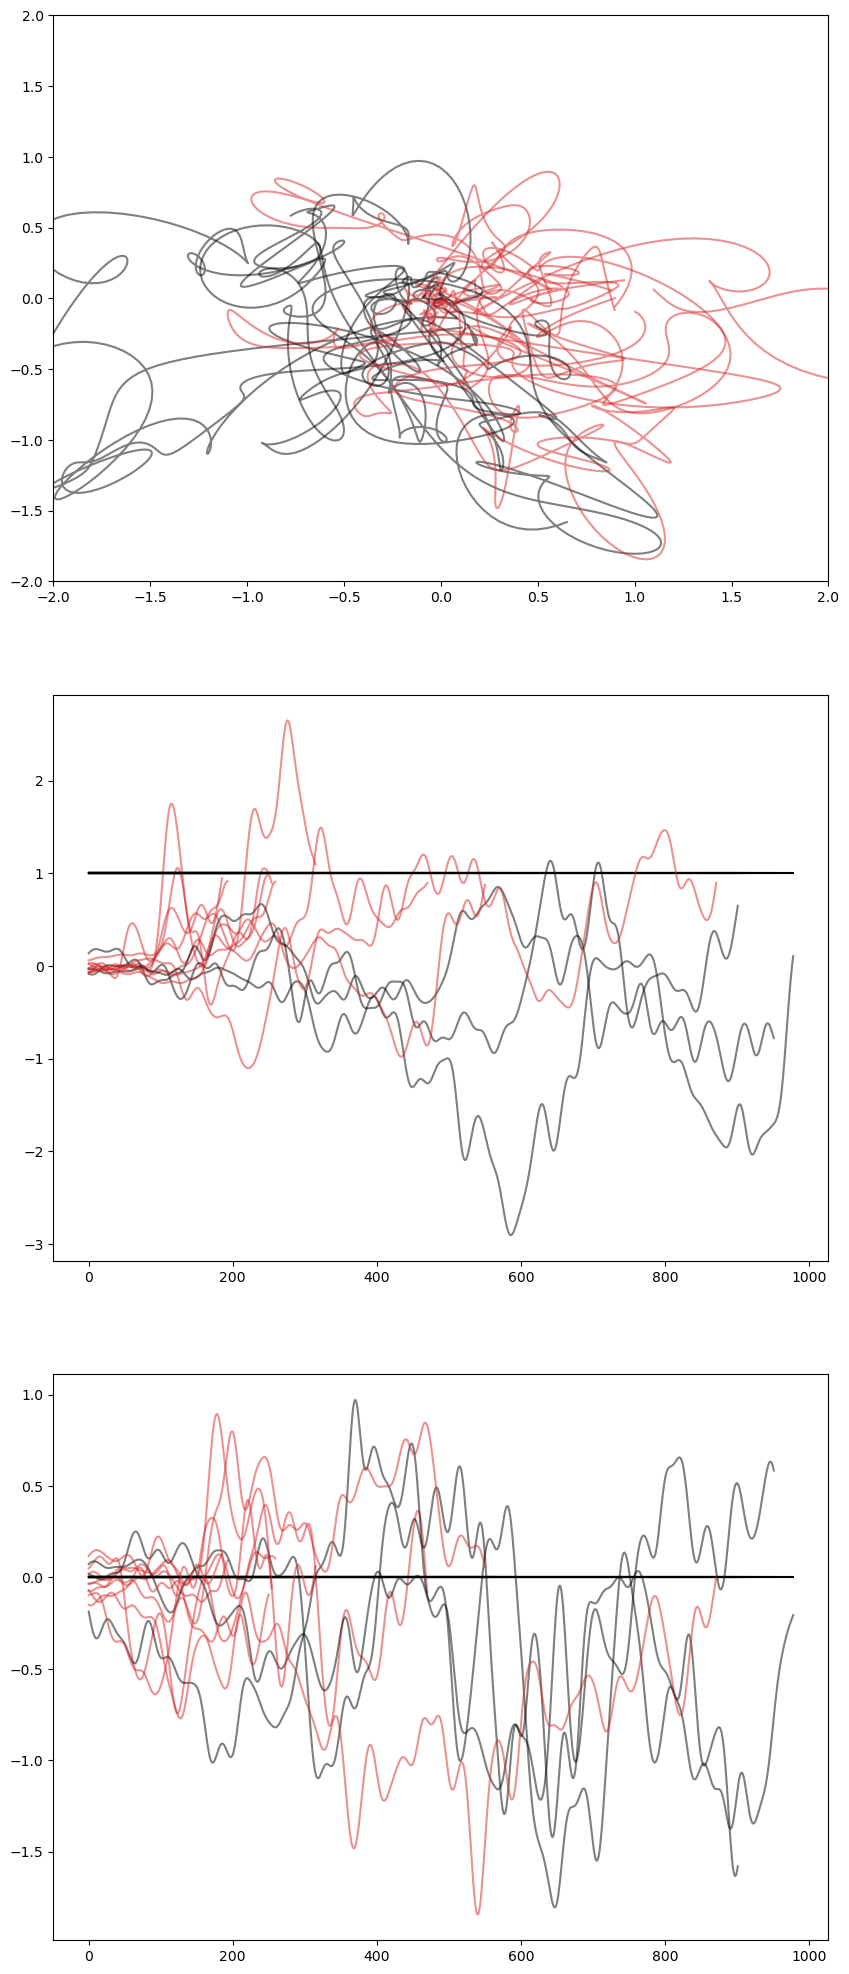

In [8]:
fig, axes = plt.subplots(3,1,figsize=(10,25))

for session in subjects[subject_idx].tasks[task_name].sorted_sessions()[session_idx:session_idx+1]:
    for trial in session.sorted_trials():
        # hold period + movement period
        if trial.outcome == "No Hold":
            continue

        target = np.array(trial.target_coords)
        R = rotation_matrix_from_target(target)
        rotated_target = R @ target
        hold_steps = int(200*trial.hold_time)
        trajectory = trial.get_trajectory()[hold_steps:,-2:]
        elbow_point = find_rise_points(trajectory)
        trajectory = trajectory[elbow_point:,:]
        trajectory = (R @ trajectory.T).T

        if trial.outcome == "Hit":
            movement_steps = int(200*trial.reach_time)
            c = "tab:red"
        elif trial.outcome == "Miss":
            movement_steps = int(trajectory.shape[0])
            c = "k"

        step_ideal = np.repeat(rotated_target[:, np.newaxis], movement_steps, axis=1).T

        axes[0].plot(step_ideal[:,0],step_ideal[:,1], "k")
        axes[1].plot(step_ideal[:,0], "k")
        axes[2].plot(step_ideal[:,1], "k")

        axes[0].plot(trajectory[:,0],trajectory[:,1], color=c, alpha=0.5)
        axes[1].plot(trajectory[:,0], color=c, alpha=0.5)
        axes[2].plot(trajectory[:,1], color=c, alpha=0.5)

axes[0].set_ylim([-2,2])
axes[0].set_xlim([-2,2])

## is the dynamic and controller controllable?

In [9]:
A = subjects[subject_idx].dynamics
D = subjects[subject_idx].decoder
N = A.shape[1]
W = D.copy()
for i in range(1,N):
    Apow = np.linalg.matrix_power(A, i)
    W = np.concatenate((W, Apow@D), axis=1)
print(W.shape)
print("rank of gramian: ", np.linalg.matrix_rank(W))
print("eigs of A: ", np.linalg.eig(A)[0])

(6, 384)
rank of gramian:  6
eigs of A:  [0. 0. 0. 0. 0. 0.]


## compare EMG activation from the end of "Hits" across trials for one target

In [10]:
def compute_subspaces(decoder):
    assert len(decoder.shape) == 2
    assert decoder.shape[0] < decoder.shape[1]
    _, _, Vt = np.linalg.svd(decoder, full_matrices=True, compute_uv=True)
    # the short side of the decoder, 2x64 in our task
    decoder_dim = decoder.shape[0]
    # task space and null space transposed
    return Vt.T[:,:decoder_dim].T, Vt.T[:,decoder_dim:].T

def mean_quadratic_form(transformation, subspace_vectors):
    # subspace vectors is orthonorm basis for subspace
    # transformation is covariance
    # for each row in x, compute x.T@A@x
    # take the average over these quadratics
    mean = 0
    dim_subspace = subspace_vectors.shape[0]
    for u in subspace_vectors:
        u = u.reshape(-1,1)
        # flatten the quadratic into a number
        mean += (u.T @ transformation @ u).ravel()
    # flatten mean into a number
    return (mean / dim_subspace).ravel()

### loop through subjects and targets for variance ratio

In [105]:
subject_hit_ratios = []
subject_miss_ratios = []
for subject_idx in range(45):
    decoder = subjects[subject_idx].decoder[-2:,:]
    task_space, null_space = compute_subspaces(decoder)
    hit_target_var_ratios = []
    miss_target_var_ratios = []
    for target_idx in range(1,13):
        emg_hit_ends = []
        emg_miss_ends = []
        for session in list(subjects[subject_idx].tasks[task_name].sorted_sessions()):
            for trial in session.sorted_trials():
                if trial.target_number == target_idx:
                    if trial.outcome == "Hit":
                        emg_hit_ends.append(np.mean(trial.get_filtered_emg()[-10:,:], axis=0))
                    elif trial.outcome == "Miss":
                        emg_miss_ends.append(np.mean(trial.get_filtered_emg()[-10:,:], axis=0))
        # needs to be greater than 1 for covariance to work
        if len(emg_hit_ends) > 1:
            emg_hit_ends = np.array(emg_hit_ends)
            emg_hit_end_cov = np.cov(emg_hit_ends.T)
            hit_task_mean = mean_quadratic_form(emg_hit_end_cov, task_space)[0]
            hit_null_mean = mean_quadratic_form(emg_hit_end_cov, null_space)[0]
            hit_target_var_ratios.append(hit_task_mean / hit_null_mean)
        # this isn't right -- need to deal with this somehow
        else:
            hit_target_var_ratios.append(0)

        if len(emg_miss_ends) > 1:
            emg_miss_ends = np.array(emg_miss_ends)
            emg_miss_end_cov = np.cov(emg_miss_ends.T)
            miss_task_mean = mean_quadratic_form(emg_miss_end_cov, task_space)[0]
            miss_null_mean = mean_quadratic_form(emg_miss_end_cov, null_space)[0]
            miss_target_var_ratios.append(miss_task_mean / miss_null_mean)
        else:
            miss_target_var_ratios.append(0)

    subject_hit_ratios.append(hit_target_var_ratios)
    subject_miss_ratios.append(miss_target_var_ratios)

#### single subject, target

In [98]:
subject_idx = 28
target_idx = 5

In [57]:
target = collection.compute_target_vec_from_number(target_idx)

hit_trials = []
emg_hit_ends = []
emg_miss_ends = []
last_points = []
hit_count = 0
for session in list(subjects[subject_idx].tasks[task_name].sorted_sessions()):
    for trial in session.sorted_trials():
        if trial.target_number == target_idx:
            if trial.outcome == "Hit":
                hit_trials.append(trial)
                last_points.append(trial.get_trajectory()[-1,-2:])
                emg_hit_ends.append(np.mean(trial.get_filtered_emg()[-10:,:], axis=0))
                hit_count += 1
            elif trial.outcome == "Miss":
                emg_miss_ends.append(np.mean(trial.get_filtered_emg()[-10:,:], axis=0))

emg_hit_ends = np.array(emg_hit_ends)
emg_miss_ends = np.array(emg_miss_ends)
emg_hit_end_grand_mean = np.mean(emg_hit_ends, axis=0)
emg_miss_end_grand_mean = np.mean(emg_miss_ends, axis=0)

Text(0, 0.5, 'Std')

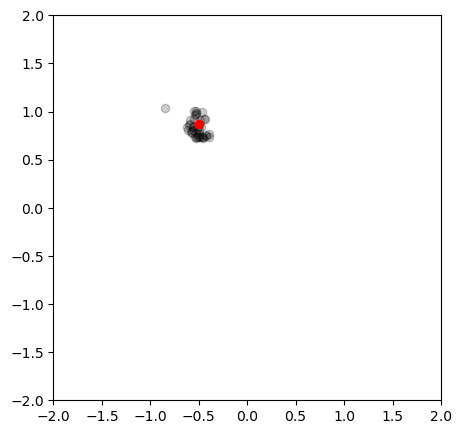

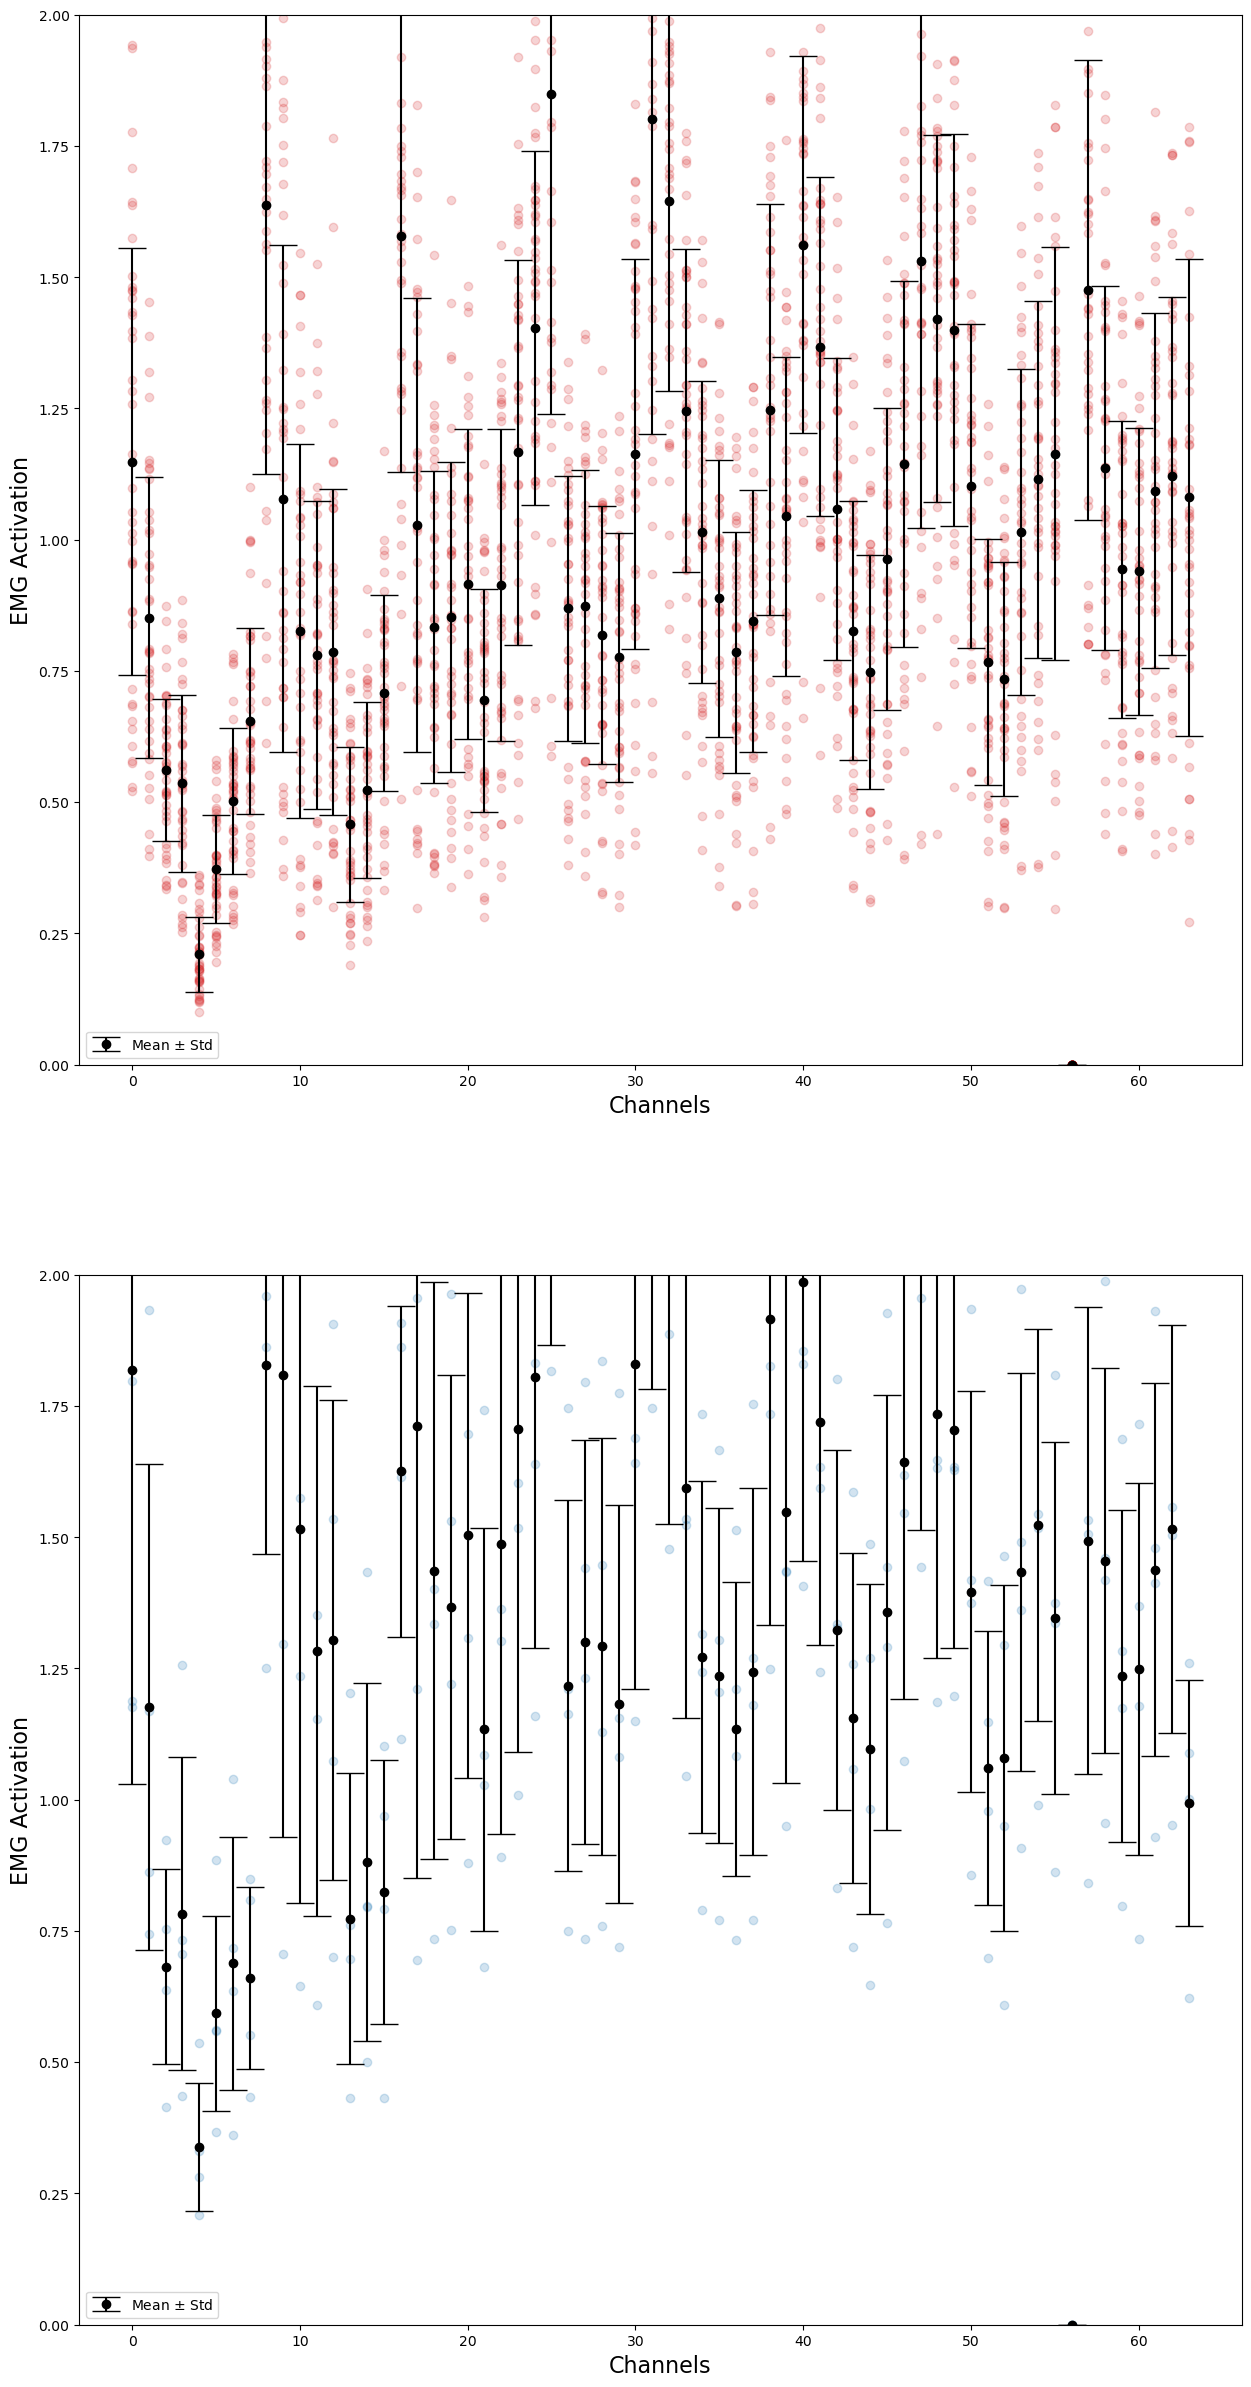

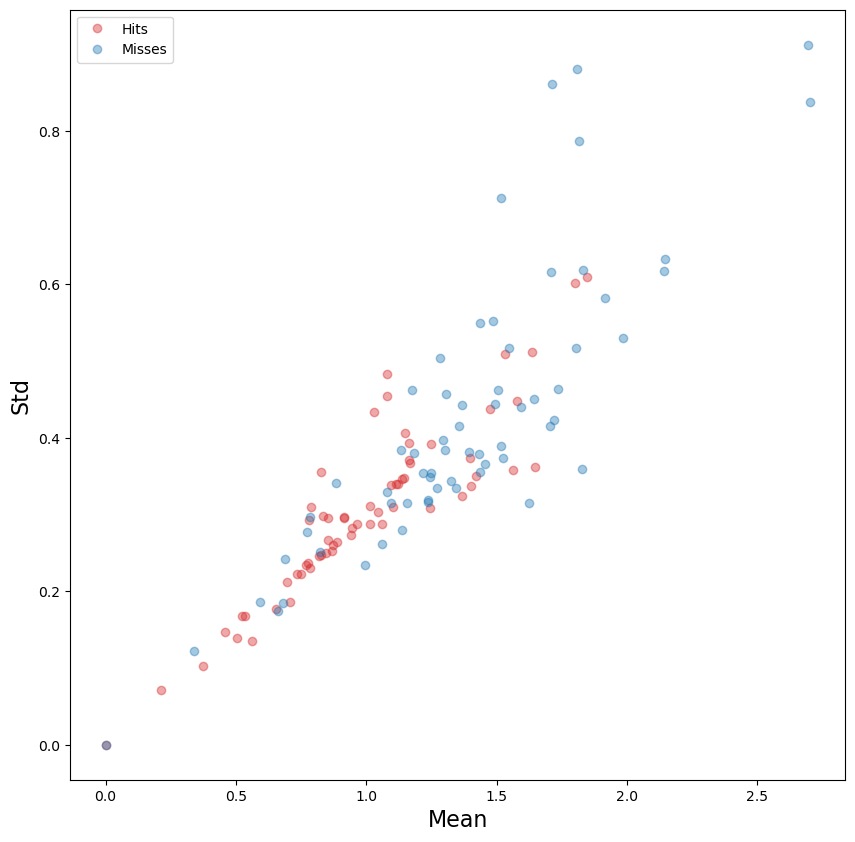

In [59]:
fig, target_ax = plt.subplots(1,1,figsize=(5,5))
fig, (emg_hit_ax, emg_miss_ax) = plt.subplots(2,1,figsize=(15,30))
target_ax.set_xlim([-2,2])
target_ax.set_ylim([-2,2])
for last_point, emg_hit_end in zip(last_points, emg_hit_ends):
    target_ax.plot(last_point[0],last_point[1],"ko",alpha=0.2)
    emg_hit_ax.plot(emg_hit_end,'o', color="tab:red", alpha=0.2)
target_ax.plot(target[0],target[1],"ro")
# emg_hit_ax.plot(emg_hit_end_grand_mean,"o", color="tab:red", )
emg_hit_ax.errorbar(np.arange(64), emg_hit_end_grand_mean, fmt="o", yerr=np.std(emg_hit_ends, axis=0),capsize=10,color="k",label="Mean $\pm$ Std")

for emg_miss_end in  emg_miss_ends:
    emg_miss_ax.plot(emg_miss_end,'o', color="tab:blue", alpha=0.2)
# emg_miss_ax.plot(emg_miss_end_grand_mean,"o", color="tab:blue", label="Mean $\pm$ Std")
emg_miss_ax.errorbar(np.arange(64), emg_miss_end_grand_mean, fmt="o", yerr=np.std(emg_miss_ends, axis=0),capsize=10,color="k",label="Mean $\pm$ Std")

emg_hit_ax.legend()
emg_hit_ax.set_xlabel("Channels")
emg_hit_ax.set_ylim([0,2])
emg_hit_ax.set_ylabel("EMG Activation")

emg_miss_ax.legend()
emg_miss_ax.set_xlabel("Channels")
emg_miss_ax.set_ylim([0,2])
emg_miss_ax.set_ylabel("EMG Activation")

fig, mean_std_ax = plt.subplots(1,1,figsize=(10,10))
mean_std_ax.plot(emg_hit_end_grand_mean, np.std(emg_hit_ends, axis=0), "o", color="tab:red", alpha=0.4, label="Hits")
mean_std_ax.plot(emg_miss_end_grand_mean, np.std(emg_miss_ends, axis=0), "o", color="tab:blue", alpha=0.4, label="Misses")
mean_std_ax.legend()
mean_std_ax.set_xlabel("Mean")
mean_std_ax.set_ylabel("Std")

Variance is correlated with mean, which we expect with "signal-dependent noise" of muscle activations?

## hit task/null variance across targets, across subjects (all trials)

In [47]:
subject_hit_ratios = np.array(subject_hit_ratios)
subject_hit_ratio_mean = np.mean(subject_hit_ratios, axis=0)
subject_hit_ratio_std = np.std(subject_hit_ratios, axis=0)

subject_miss_ratios = np.array(subject_miss_ratios)
subject_miss_ratio_mean = np.mean(subject_miss_ratios, axis=0)
subject_miss_ratio_std = np.std(subject_miss_ratios, axis=0)

(45, 12) (12,) (12,)
(45, 12) (12,) (12,)


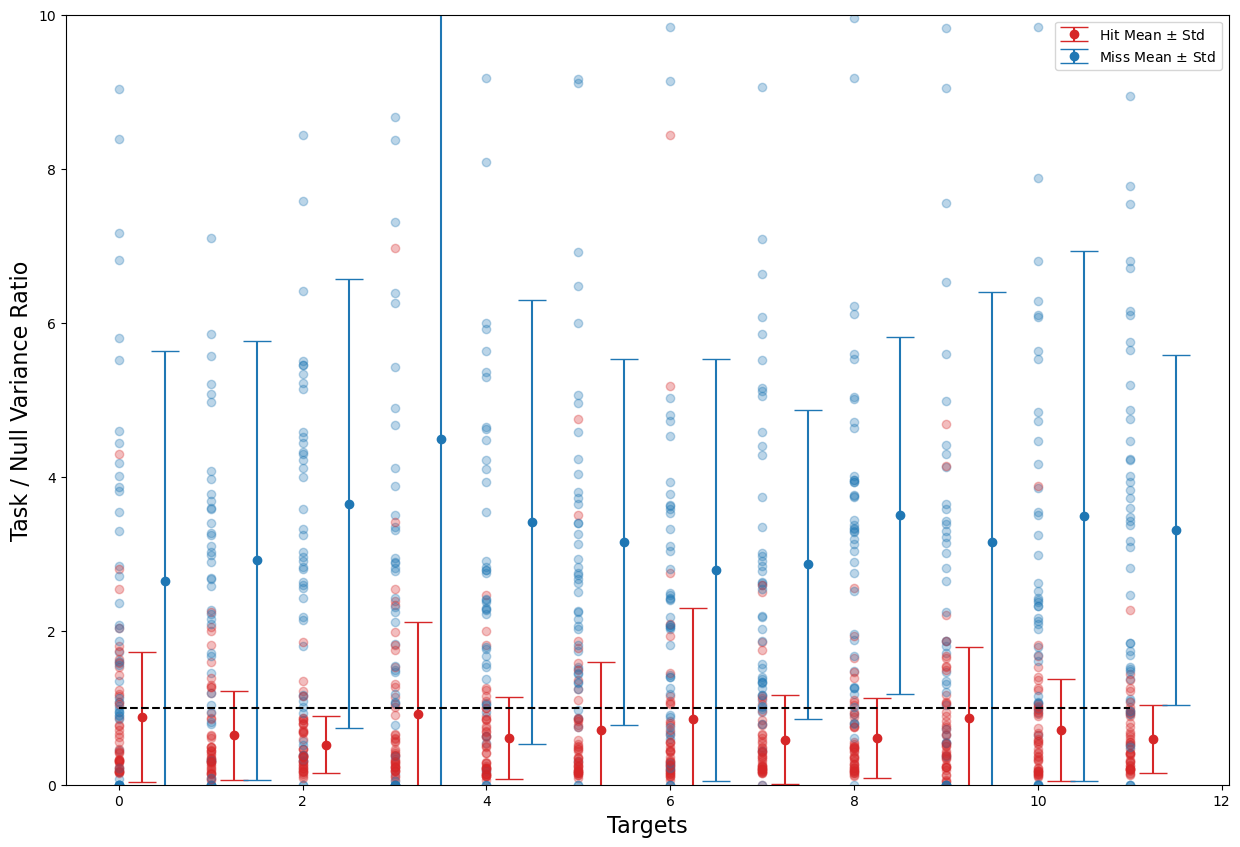

In [62]:
plt.figure(figsize=(15,10))
for hit_ratios, miss_ratios in zip(subject_hit_ratios, subject_miss_ratios):
    plt.plot(hit_ratios,"o", color="tab:red", alpha=0.3)
    plt.plot(miss_ratios,"o", color="tab:blue", alpha=0.3)
    plt.ylim([0,10])
    plt.xlabel("Targets")
    plt.ylabel("Task / Null Variance Ratio")
plt.errorbar([x+0.25 for x in range(12)], subject_hit_ratio_mean, yerr=subject_hit_ratio_std, fmt="o", capsize=10,color="tab:red",label="Hit Mean $\pm$ Std")
plt.errorbar([x+0.5 for x in range(12)], subject_miss_ratio_mean, yerr=subject_miss_ratio_std, fmt="o", capsize=10,color="tab:blue",label="Miss Mean $\pm$ Std")
plt.legend()
plt.plot(range(12), np.ones(12), "k--")